<a href="https://colab.research.google.com/github/kiyong21c/nadocoding/blob/master/20220525_kernel_featuremap_visualize_fuctionalAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망의 시각화
 - 합성곱 신경망은 이미지의 특징을 찾아서 압축하는데 효과적

## 가중치 시각화
 - 일반적으로 절편은 시각적으로 의미가 있지 않음
 - 가중치는 입력 이미지의 어떤 특징을 두드러지게 표현하는 역할

In [2]:
from tensorflow import keras
model = keras.models.load_model('best-cnn-model.h5')
# /content 폴더에 저장되고, /content 폴더에 저장되어 있어야 불러올수 있다

In [3]:
model.layers # layers 속성에 저장된 [층, 층, 층...]

In [4]:
conv = model.layers[0] # 합성곱 층
print(conv.weights[0].shape, conv.weights[1].shape) # weights 속성에 저장된 [가중치, 절편] 

(3, 3, 1, 32) (32,)


- 커널 크기를 (3,3) 지정, keras 합성곱 층에 전달되는 입력은 깊이(1)를 가지므로 실제 커널 크기는 (3,3,1) 또 필터 개수가 32개 이므로 가중치 크기는 (3,3,1,32)
- 필터마다 1개의 절편이 있으므로 (32,)
- wights속성은 텐서플로의 다차원 배열인 Tensor 클래스의 객체

In [5]:
conv_weights = conv.weights[0].numpy() # 다루기 쉽도록 배열 변경 : Tensor → array
print(conv_weights.mean(), conv_weights.std())

-0.020665165 0.22895478


- 가중치의 평균값과 표준편차를 구하여 어떤 분포를 가졌는지 확인(히스토그램)

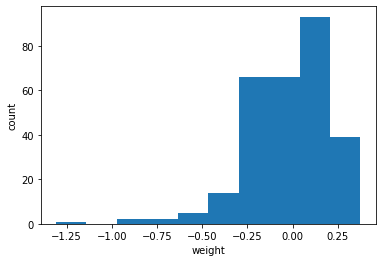

In [6]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1,1)) # hist()함수는 1차원 배열이 필요함 → 1개의 열이 있는 배열로 변환
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

 - 0을 중심으로 종 모양 분포

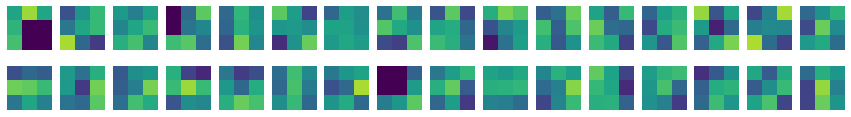

In [7]:
# 32개의 커널을 16개씩 두줄에 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2)) 
for i in range(2): # 행 : 1행에 16열 → 2행 16열 순서이므로
    for j in range(16): # 열
        axs[i, j].imshow(conv_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        # conv_weights는 커널이며 (3,3,1,32)
        axs[i, j].axis('off')
plt.show()

- 밝은 부분의 픽셀이 값이 높다

훈련전/후의 가중치가 어떻게 다른지 확인해 보자

In [8]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation=\
                                          'relu', padding='same', input_shape=(28,28,1)))

In [9]:
no_training_conv = no_training_model.layers[0] # 합성곱 층
no_training_weights = no_training_conv.weights[0].numpy() # 합성곱 층의 가중치를 array로
print(no_training_weights.mean(), no_training_weights.std())

-0.003479021 0.08425633


- 평균은 훈련후와 비슷하게 0에 가깝지만 표준편차는 매우 작다

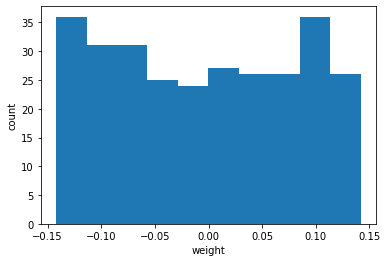

In [10]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

- 대부분 가중치가 -0.15 ~ 0.15 사이에 고르게 분포
- **텐서플로가 신경망의 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택함**

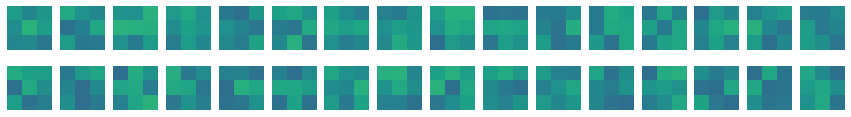

In [11]:
# 32개의 커널을 16개씩 두줄에 출력
fig, axs = plt.subplots(2, 16, figsize=(15,2)) 
for i in range(2): # 행 : 1행에 16열 → 2행 16열 순서이므로
    for j in range(16): # 열
        axs[i, j].imshow(no_training_weights[:,:,0,i*16+j], vmin=-0.5, vmax=0.5)
        # no_training_weights는 커널이며 (3,3,1,32)
        axs[i, j].axis('off')
plt.show()

- 가중치가 밋밋하게 초기화 되어 있음
- **합성곱 신경망이 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습한 것을 확인할 수 있음**

## 함수형 API
 - 이전까지는 신경망 모델 만들 때 케라스 Sequential 클래스 사용(층을 차례로 쌓은 모델)
 - 복잡한 모델에 사용(예 : 입/출력이 2개 등)
 - **케라스의 Model 클래스 사용**

> dense1 = keras.layers.Dense(100, activation='sigmoid')

>dense2 = keras.layers.Dense(10, activation='softmax')

Dense층 객체를 Sequential 클래스 객체의 add()메서드에 전달할 수 있고, 함수처럼 호출할 수 있다

*dense1층 호출*
>hidden = dense1(inputs)

- 케라스의 층은 객체를 함수처럼 호출했을때 적절히 동작할 수 있도록 미리 준비되어 있다
- 입력값 inputs를 dense1층에 통과시킨 후의 출력값 hidden을 만들어 줌

*dense2층 호출*
>outputs = dense(hidden)

- 첫번째 층의 출력값인 hidden을 입력값으로 사용


*inputs와 outputs을 Model 클래스로 연결*
>model = keras.Model(inputs, outputs)

### 함수형 API를 위한 Model 클래스 사용시 inputs은 무엇인가?
 - 케라스 모델은 layers 속성외에 _layers 리스트 속성을 따로 가지고 있음
 - _layers 리스트 속성의 첫번째 항목이 InputLayer 클래스 객체
 - InputLayer 클래스는 신경망의 입력층 역할
 - 즉, 모델의 입력을 첫번째 은닉층에 전달하는 역할

- Sequential 클래스는 InputLayer클래스를 자동으로 추가/호출해 줌
- Model 클래스는 수동으로 만들어서 호출해야 함
>inputs = keras.Input(shape=(784,))

### 특성 맵 시각화를 만드는데 왜 함수형 API가 필요한가?
 - Model클래스를 사용하여 만든 모델 객체는 중간의 층을 연결하여 새로운 모델을 얻을 수 있다
 - model 객체의 입력과 Conv2D의 출력을 연결하여 새로운 모델 생성가능
 >conv_acti = keras.Model(model.input, layers[0].output)
 

In [12]:
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [13]:
conv_acti = keras.Model(model.input, model.layers[0].output)

predict()
- model 객체의 predict() 메서드를 호출하면 최종 출력층의 확률을 반환
- conv_acti 객체의 predict() 메서드를 호출하면 첫번째 Conv2D의 출력을 반환

- Conv2D의 출력은 각 커널을 지난 특성 맵

주의사항
 - predict() 메서드에 들어갈 입력의 첫번째 차원은 **배치차원** 이어야함
 - (28, 28)이 아닌 순서가 있는, 즉, 슬라이싱 할수 있는 (1, 28, 28) 형태여야 함
 - **전체가 하나의 덩어리(tensor) 임을 나타내기위함**

### 특성 맵 시각화

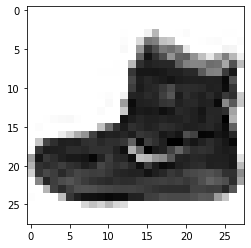

In [17]:
(train_input, train_target), (test_input, test_target) =\
keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

- 위 샘플을 conv_acti 모델에 주입하여 Conv2D층이 만드는 특성 맵을 출력해보자

In [23]:
# predict(inputs) : predict의 입력값 inputs의 첫번째 차원이 배치데이터 이어야함
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)

In [24]:
feature_maps.shape # 32개의 필터를 사용했으므로 마지막 차원은 32

(1, 28, 28, 32)

- 세임패딩, 32개 필터 사용한 합성곱 층 : (28, 28, 32)
- 첫번째 차원은 배치차원 : 샘플을 하나 입력했으므로 1


In [19]:
train_input[0].shape # (28, 28)
train_input[0:1].shape # (1, 28, 28)

(1, 28, 28)

In [20]:
train_input[0:1].reshape(-1,28,28,1).shape

(1, 28, 28, 1)

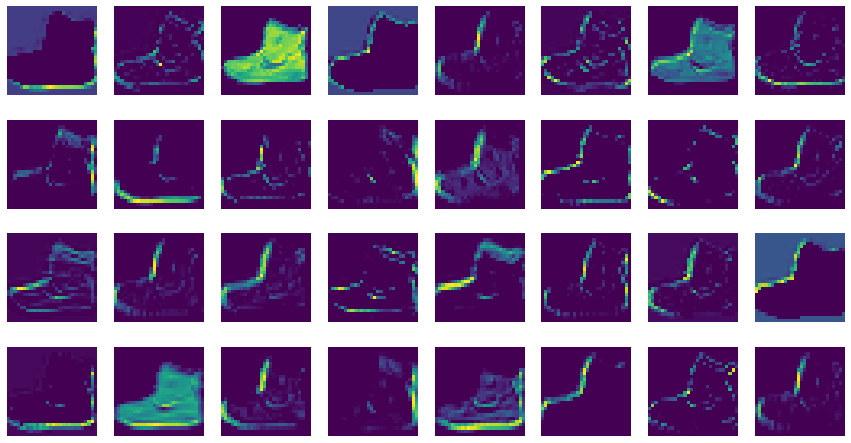

In [25]:
# 특성맵 출력(합성곱 층의 출력 : 32개의 각 커널을 지난 특성맵 32개)
fig, axs = plt.subplots(4, 8, figsize=(15, 8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
        axs[i, j].axis('off')
plt.show()

- 두번째 합성곱 층이 만든 특성 맵을 확인해보자


In [26]:
conv2_acti = keras.Model(model.input, model.layers[2].output)

In [27]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)

In [28]:
feature_maps.shape

(1, 14, 14, 64)

- 두번째 합성곱 층에서는 풀링을 거치면서 가로/세로 크기가 절반으로 줄었고, 필터 개수는 64개
- feature_maps의 크기는 배치 차원을 제외하면 (14, 14, 64)

배치차원
 - 슬라이싱 할 수 있는 차원
 - **전체가 하나의 덩어리(tensor) 임을 나타내기위함**

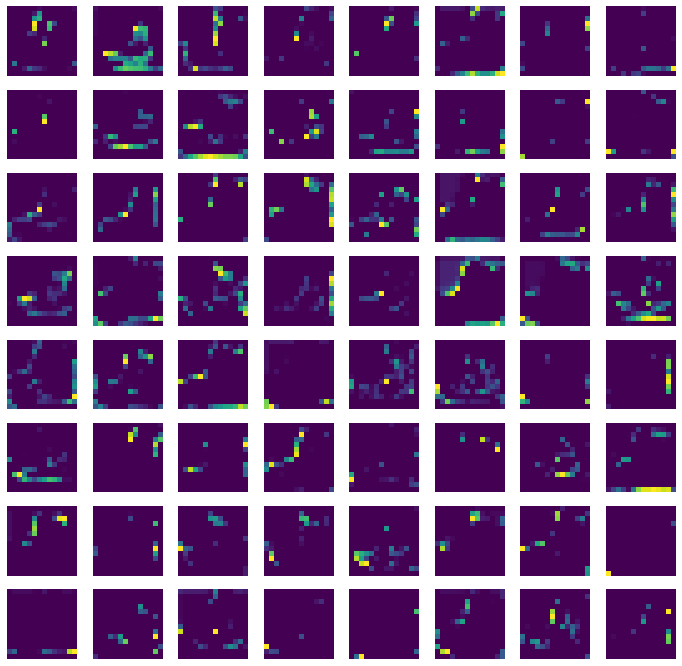

In [29]:
fig, axs = plt.subplots(8,8, figsize=(12,12))
for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8+j])
        axs[i, j].axis('off')
plt.show()

- 두번째 합성곱 층의 필터 크기는 (3,3,32)
- 두번째 합성곱 층의 첫번째 필터(64개중)가 앞서 출력한 32개의 특성 맵과 곱해져 두번째 합성곱층의 첫번째 특성 맵이 된다 